In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataframe synthétique

Aperçu du DataFrame :
                Ventes  Tendance  Saisonnalité     Bruit
2020-01-31  104.594206       100      0.000000  4.594206
2020-02-29  102.570802       102     10.000000 -9.429198
2020-03-31  124.926982       104     17.320508  3.606474
2020-04-30  126.532958       106     20.000000  0.532958
2020-05-31  125.571509       108     17.320508  0.251001


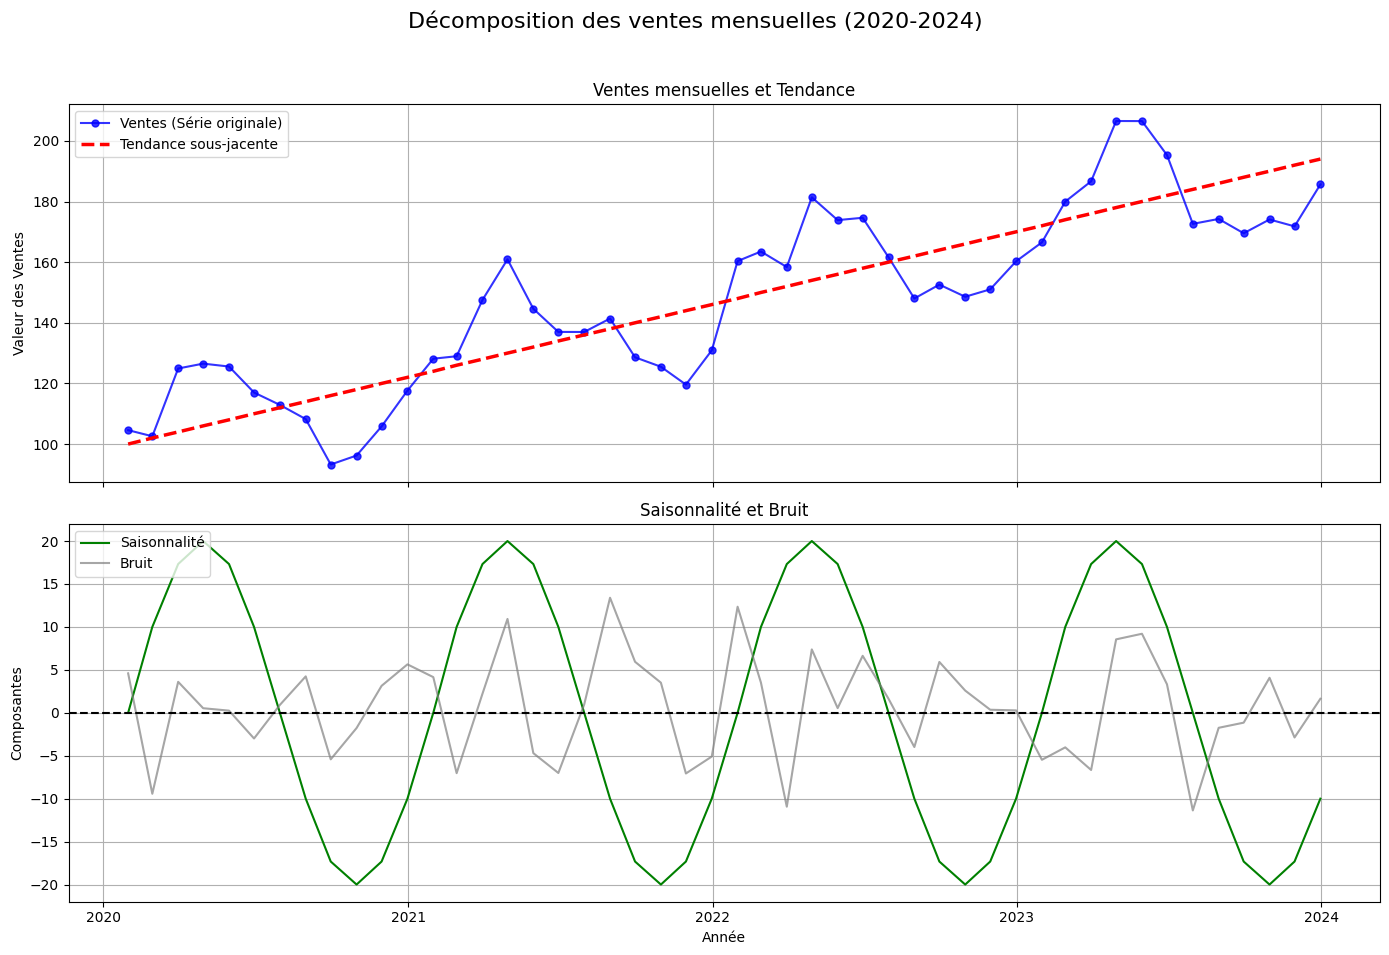

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Paramètres de la simulation ---
n = 48  # Nombre de périodes (60 mois = 5 ans)
t = np.arange(n)
beta0 = 100  # Niveau de base
beta1 = 2    # Pente de la tendance
A = 20       # Amplitude de la saisonnalité
P = 12       # Périodicité (12 mois)
sigma = 5    # Écart-type du bruit

# --- Génération des composantes ---
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)

# Série temporelle (Ventes)
sales = trend + seasonality + noise

# --- Création du DataFrame ---
# Utilisation de 'ME' (Month End) pour une fréquence mensuelle sur 5 ans
date_index = pd.date_range(start='2020-01-01', periods=n, freq='ME')
df = pd.DataFrame({
    'Ventes': sales,
    'Tendance': trend,
    'Saisonnalité': seasonality,
    'Bruit': noise
}, index=date_index)

print("Aperçu du DataFrame :")
print(df.head())

# --- Visualisation ---
# Création d'une figure avec 2 sous-graphiques (2 lignes, 1 colonne)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Décomposition des ventes mensuelles (2020-2024)', fontsize=16)

# 1. Graphique : Ventes et Tendance
ax1.plot(df.index, df['Ventes'], marker='o', linestyle='-', color='b', label='Ventes (Série originale)', markersize=5, alpha=0.8)
ax1.plot(df.index, df['Tendance'], linestyle='--', color='red', label='Tendance sous-jacente', linewidth=2.5)
ax1.set_title('Ventes mensuelles et Tendance')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_ylabel('Valeur des Ventes')

# 2. Graphique : Saisonnalité et Bruit
ax2.plot(df.index, df['Saisonnalité'], linestyle='-', color='g', label='Saisonnalité')
ax2.plot(df.index, df['Bruit'], linestyle='-', color='grey', alpha=0.7, label='Bruit')
ax2.axhline(0, linestyle='--', color='black') # Ligne zéro pour référence
ax2.set_title('Saisonnalité et Bruit')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.set_ylabel('Composantes')

# Formatage de l'axe des x (partagé)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Année')

# Ajustement de la mise en page
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Afficher le graphique
plt.show()



# Modèle naif

/tmp/ipython-input-3527177465.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start='2020-01-01', periods=n, freq='M')


--- Aperçu du jeu de validation (avant calcul) ---
                Ventes  Prediction_Naive
2023-03-31  186.679578        174.201649
2023-04-30  198.984306        186.679578
2023-05-31  201.012841        198.984306
2023-06-30  192.856841        201.012841
2023-07-31  183.421759        192.856841

--- Métriques du Modèle Naïf (Baseline) ---
MSE:      100.3396
MAE:      9.0536
RMSE:     10.0170
MAPE (%): 4.9501
R2 Score: 0.3648

--- Métriques Sauvegardées ---
Fichier sauvegardé avec succès dans : /content/drive/MyDrive/Time_series/naive_model_metrics.json


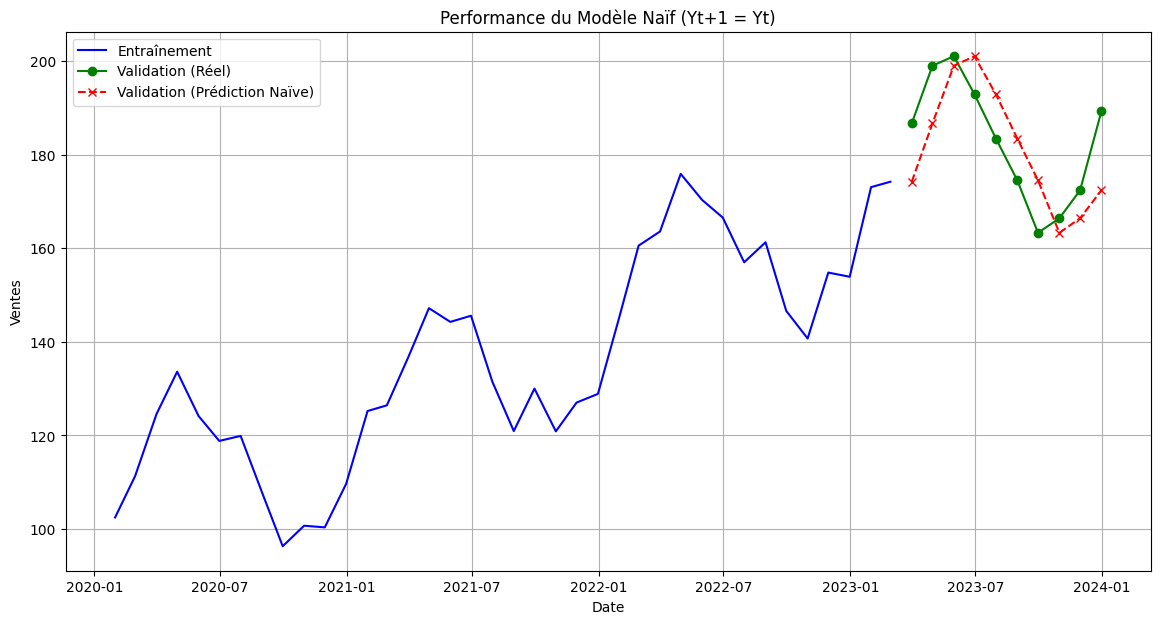

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import os  # <--- AJOUTÉ
import json # <--- AJOUTÉ

# --- 1. Fonction de Métriques ---
def calculer_metriques(y_true, y_pred):
    """
    Calcule un dictionnaire de métriques de régression (MSE, MAE, RMSE, MAPE, R2).
    Gère les NaNs en les supprimant des paires (true, pred) avant le calcul.
    """

    # S'assurer que les entrées sont des Séries pandas pour un alignement
    # et une suppression de NaN fiables
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)

    # Combiner pour supprimer les NaNs de manière cohérente
    # Si une valeur est NaN dans y_true OU y_pred, la ligne est supprimée
    temp_df = pd.DataFrame({'true': y_true, 'pred': y_pred}).dropna()

    y_true_clean = temp_df['true']
    y_pred_clean = temp_df['pred']

    # Gérer le cas où il n'y a plus de données après le nettoyage
    if len(y_true_clean) == 0:
        return {
            "MSE": np.nan,
            "MAE": np.nan,
            "RMSE": np.nan,
            "MAPE": np.nan,
            "R2_Score": np.nan,
        }

    # Calcul des métriques
    mse = mean_squared_error(y_true_clean, y_pred_clean)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)

    metriques = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape * 100,  # Affiché en pourcentage
        'R2_Score': r2
    }
    return metriques

# --- 2. Simulation des Données (pour un exemple autonome) ---
np.random.seed(42)  # Pour la reproductibilité
n = 48
t = np.arange(n)
trend = 100 + 2 * t
seasonality = 20 * np.sin(2 * np.pi * t / 12)
noise = np.random.normal(0, 5, n)
sales = trend + seasonality + noise

# Utilisation de 'M' pour 'Month End Frequency'
date_index = pd.date_range(start='2020-01-01', periods=n, freq='M')
df = pd.DataFrame({'Ventes': sales}, index=date_index)

# --- 3. Préparation (Split et Modèle Naïf) ---

# Créer la prédiction naïve (Y_t = Y_{t-1})
df['Prediction_Naive'] = df['Ventes'].shift(1)

# Diviser les données (split 80/20)
split_point = int(len(df) * 0.8)
train = df.iloc[0:split_point]
valid = df.iloc[split_point:].copy()

print("--- Aperçu du jeu de validation (avant calcul) ---")
print(valid.head())

# --- 4. Évaluation du Modèle Naïf ---

# Extraire les valeurs réelles et prédites du set de validation
y_true_naive = valid['Ventes']
y_pred_naive = valid['Prediction_Naive']

# Calculer les métriques en utilisant notre fonction
metriques_naive = calculer_metriques(y_true_naive, y_pred_naive)

print("\n--- Métriques du Modèle Naïf (Baseline) ---")
print(f"MSE:      {metriques_naive['MSE']:.4f}")
print(f"MAE:      {metriques_naive['MAE']:.4f}")
print(f"RMSE:     {metriques_naive['RMSE']:.4f}")
print(f"MAPE (%): {metriques_naive['MAPE']:.4f}")
print(f"R2 Score: {metriques_naive['R2_Score']:.4f}")

# --- 4b. Sauvegarde des Métriques (BLOC AJOUTÉ) ---
try:
    # Définir le chemin de sauvegarde
    save_directory = "/content/drive/MyDrive/Time_series"
    file_name = "naive_model_metrics.json"
    full_file_path = os.path.join(save_directory, file_name)

    # Créer le dossier (si besoin)
    os.makedirs(save_directory, exist_ok=True)

    # Sauvegarder le fichier JSON
    with open(full_file_path, 'w') as json_file:
        json.dump(metriques_naive, json_file, indent=4)

    print(f"\n--- Métriques Sauvegardées ---")
    print(f"Fichier sauvegardé avec succès dans : {full_file_path}")

except Exception as e:
    print(f"\n--- Erreur de Sauvegarde ---")
    print(f"ATTENTION : Échec de la sauvegarde des métriques.")
    print(f"Assurez-vous que votre Drive est bien monté à '/content/drive'.")
    print(f"Erreur : {e}")
# --- Fin du bloc ajouté ---


# --- 5. Visualisation ---
plt.figure(figsize=(14, 7))
plt.title('Performance du Modèle Naïf (Yt+1 = Yt)')
plt.plot(train.index, train['Ventes'], label='Entraînement', color='blue')
plt.plot(valid.index, valid['Ventes'], label='Validation (Réel)', color='green', marker='o')
plt.plot(valid.index, valid['Prediction_Naive'], label='Validation (Prédiction Naïve)', color='red', linestyle='--', marker='x')

plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True)
plt.show()

# Modèle Regression Simple

Création de la feature 'time_idx'...
Feature 'time_idx' créée.

--- 1. Chargement du Modèle Naïf (Baseline) ---
Métriques Naïves chargées depuis /content/drive/MyDrive/Time_series/naive_model_metrics.json

--- 2. Entraînement du modèle Régression Linéaire ---
Régression Linéaire entraînée.

--- 3. Calcul des métriques (Régression Linéaire) ---

--- 4. Comparaison des Modèles ---
          Naive_Baseline  Regression_Lineaire
MSE             100.3396             303.4350
MAE               9.0536              15.0623
RMSE             10.0170              17.4194
MAPE              4.9501               8.0783
R2_Score          0.3648              -0.9210

--- 5. Génération du graphique de comparaison ---


/tmp/ipython-input-3099324004.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['time_idx'] = np.arange(len(train))


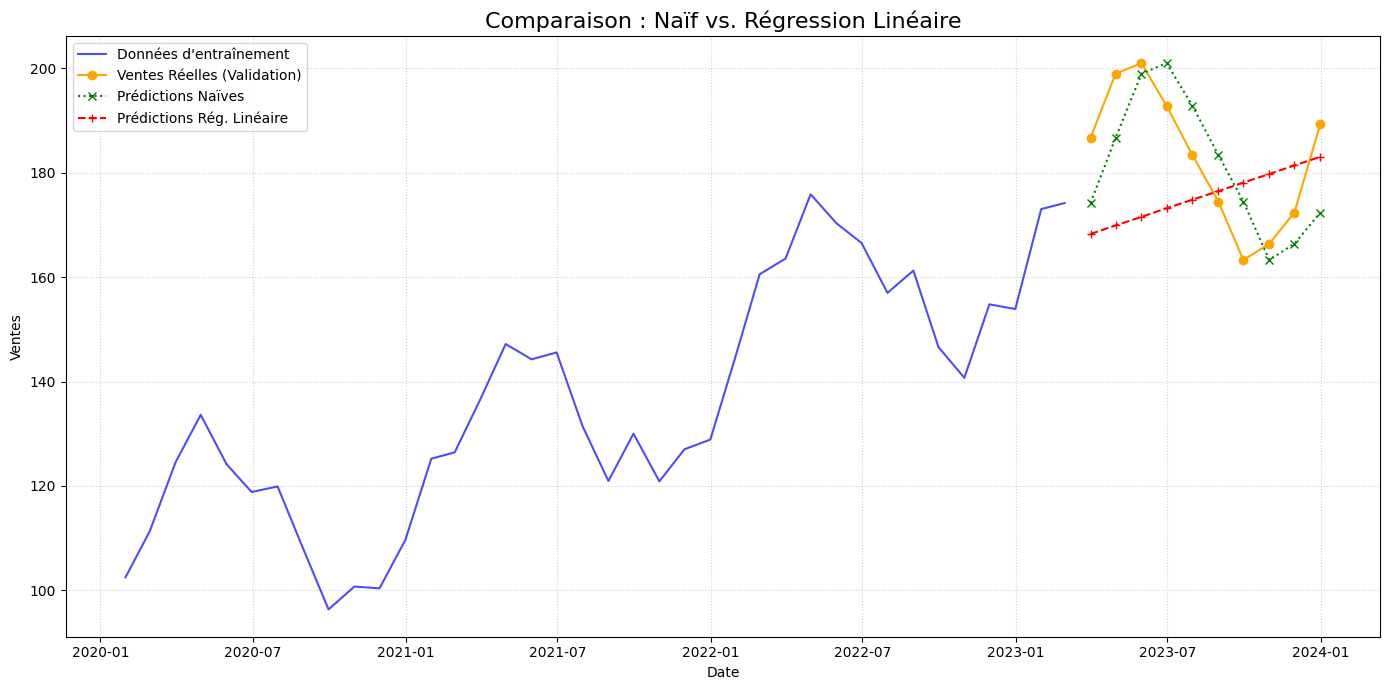

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- 1. Préparation pour la Régression Linéaire ---

# Votre code utilise 'time_idx'. Nous devons la créer.
# C'est juste un compteur numérique (0, 1, 2, 3...)
# On s'assure qu'il est continu entre train et valid
try:
    print("Création de la feature 'time_idx'...")
    train['time_idx'] = np.arange(len(train))
    valid['time_idx'] = np.arange(len(train), len(train) + len(valid))
    print("Feature 'time_idx' créée.")
except NameError:
    print("Erreur: Le DataFrame 'train' ou 'valid' n'a pas été trouvé.")
    print("Veuillez d'abord exécuter le script précédent.")
    # On arrête ici si les DFs n'existent pas
    raise

# --- 2. Chargement des métriques du modèle Naïf (Baseline) ---
# Comme demandé, nous chargeons le JSON pour la comparaison
print("\n--- 1. Chargement du Modèle Naïf (Baseline) ---")
baseline_metrics_path = "/content/drive/MyDrive/Time_series/naive_model_metrics.json"

try:
    with open(baseline_metrics_path, 'r') as f:
        metriques_naive = json.load(f)
    print(f"Métriques Naïves chargées depuis {baseline_metrics_path}")
except Exception as e:
    print(f"ERREUR: Impossible de charger le fichier de baseline : {e}")
    # On crée un dict vide pour éviter que le script plante
    metriques_naive = {}


# --- 3. Entraînement du modèle Régression Linéaire ---
print("\n--- 2. Entraînement du modèle Régression Linéaire ---")
features = ['time_idx']
X_train = train[features]
y_train = train['Ventes']

# Note : J'utilise 'valid' ici, car c'est le nom que nous avons
# utilisé pour notre set de test/validation.
X_valid = valid[features]
y_valid = valid['Ventes'] # Pour le calcul des métriques

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)
print("Régression Linéaire entraînée.")

# --- 4. Prévision et Évaluation ---

# Prévision Régression
# .predict() retourne un array numpy, on le remet dans une Série
# pour l'aligner sur l'index de 'valid' (pour le graphe et les métriques)
predictions_reg = pd.Series(model_reg.predict(X_valid), index=valid.index)

# Ajoutons les prédictions au DataFrame 'valid' pour le graphique
valid['Prediction_RegLin'] = predictions_reg

print("\n--- 3. Calcul des métriques (Régression Linéaire) ---")
# On suppose que la fonction 'calculer_metriques' existe en mémoire
try:
    metriques_reg = calculer_metriques(y_valid, predictions_reg)
except NameError:
    print("Erreur: La fonction 'calculer_metriques' n'a pas été trouvée.")
    raise

# --- 5. Comparaison des Modèles ---
print("\n--- 4. Comparaison des Modèles ---")

# Mettre les métriques Naïves dans un DataFrame
df_naive = pd.DataFrame.from_dict(metriques_naive, orient='index', columns=['Naive_Baseline'])

# Créer un DataFrame pour les métriques de Régression
df_reg = pd.DataFrame.from_dict(metriques_reg, orient='index', columns=['Regression_Lineaire'])

# Combiner les deux pour comparer
df_compare = df_naive.join(df_reg)

# Afficher la comparaison
# .round(4) est juste pour un affichage plus propre
print(df_compare.round(4))

# --- 6. Visualisation ---
print("\n--- 5. Génération du graphique de comparaison ---")
plt.figure(figsize=(14, 7))
plt.title('Comparaison : Naïf vs. Régression Linéaire', fontsize=16)

# Données
plt.plot(train.index, train['Ventes'], label='Données d\'entraînement', color='blue', alpha=0.7)
plt.plot(valid.index, valid['Ventes'], label='Ventes Réelles (Validation)', color='orange', marker='o', linestyle='-')

# Modèles
# On suppose que 'Prediction_Naive' existe déjà sur 'valid'
plt.plot(valid.index, valid['Prediction_Naive'], label='Prédictions Naïves', color='green', linestyle=':', marker='x')
plt.plot(valid.index, valid['Prediction_RegLin'], label='Prédictions Rég. Linéaire', color='red', linestyle='--', marker='+')

plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Régression Linéaire "Fenêtrée" (avec 1 neurone)

In [ ]:
!pip install tensorflow

/tmp/ipython-input-1122867018.py:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start='2000-01-01', periods=n, freq='M')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Taille totale: 180, Train: 144, Valid: 36
Set de validation : 2012-01-31 à 2014-12-31

--- Évaluation Modèle 1: Naïf ---

--- Évaluation Modèle 2: Régression Linéaire ---

--- Évaluation Modèle 3: Réseaux de Neurones (multi-W) ---

Entraînement du NN avec W = 5...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entraînement W=5 terminé.

Entraînement du NN avec W = 20...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Entraînement W=20 terminé.

Entraînement du NN avec W = 30...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Entraînement W=30 terminé.

--- 🏁 Comparaison Équitable Finale 🏁 ---
Comparaison sur les 6 dernières observations (défini par W_max=30):

          Naive_Baseline  Regression_Lineaire    NN_(W=5)  NN_(W=20)  \
MSE             206.2771             175.3327  66527.6341   230.6138   
MAE              12.0721              11.4701    257.6076    13.7827   
RMSE             14.3624              13.2413    257.9295    15.1860   
MAPE              3.3622               3.2874     72.7767     3.8745   
R2_Score         -0.8394              -0.5634   -592.2282    -1.0564   

          NN_(W=30)  
MSE        403.9214  
MAE         16.0470  
RMSE        20.0978  
MAPE         4.5286  
R2_Score    -2.6018  

--- Génération du graphique de comparaison ---


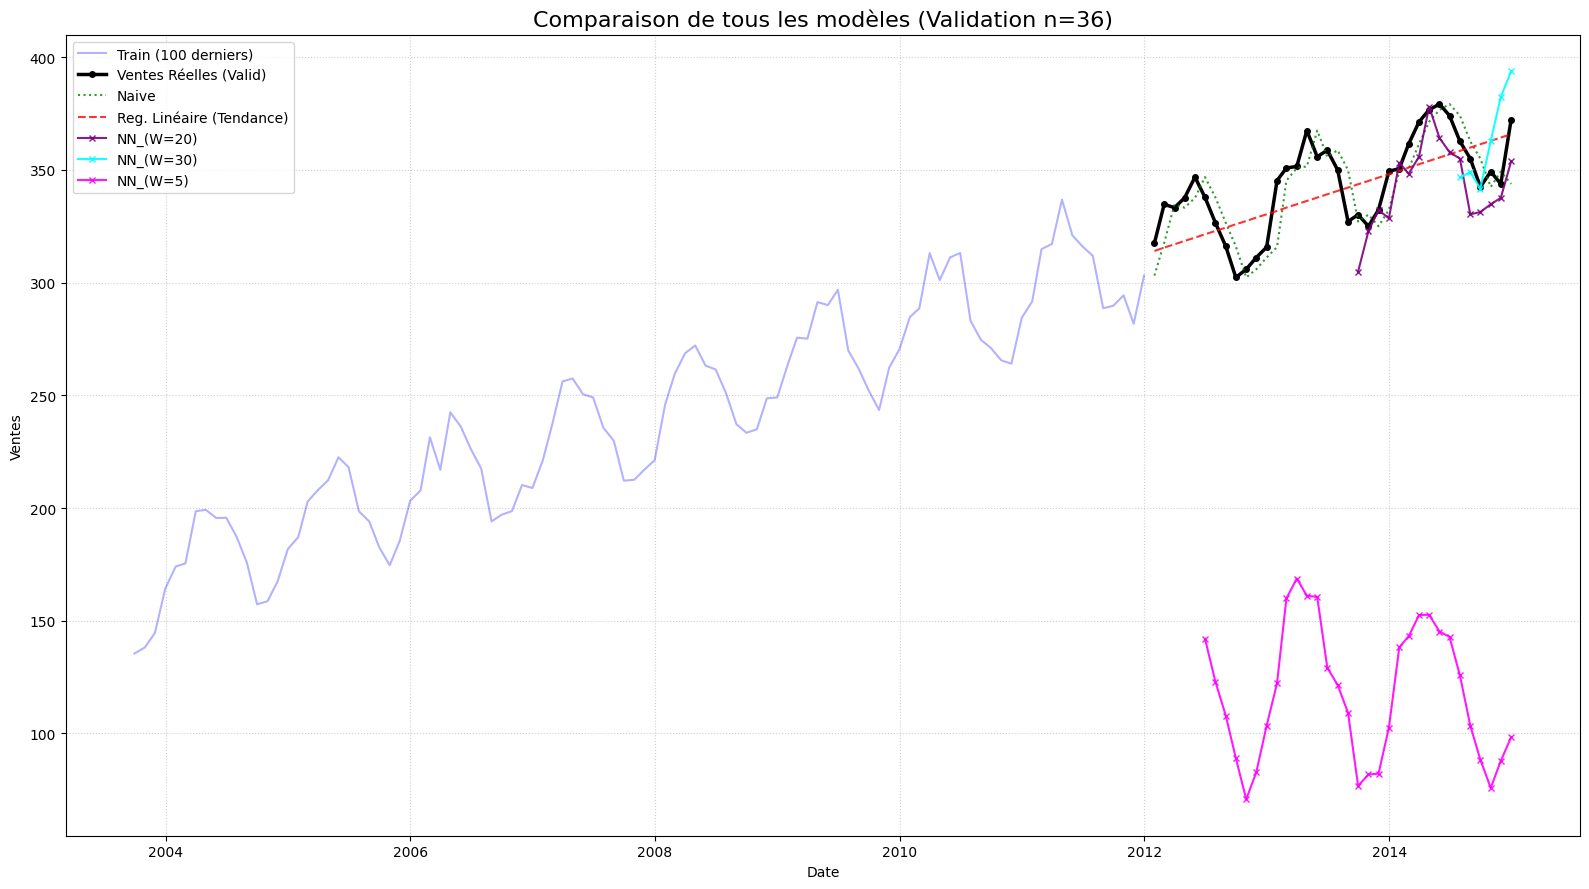

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import os

# Imports Scikit-Learn
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Imports TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Supprimer les avertissements TF superflus
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# --- 1. Fonction de Métriques (inchangée) ---
def calculer_metriques(y_true, y_pred):
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)

    temp_df = pd.DataFrame({'true': y_true, 'pred': y_pred}).dropna()
    y_true_clean = temp_df['true']
    y_pred_clean = temp_df['pred']

    if len(y_true_clean) == 0:
        return {"MSE": np.nan, "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R2_Score": np.nan}

    mse = mean_squared_error(y_true_clean, y_pred_clean)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse,
        'MAPE': mape * 100, 'R2_Score': r2
    }

# --- 2. Simulation des Données (Ajustée) ---
np.random.seed(42)
n = 180  # CHANGEMENT: 15 ans de données (plus petit que 300)
t = np.arange(n)
trend = 100 + 1.5 * t
seasonality = 25 * np.sin(2 * np.pi * t / 12)
noise = np.random.normal(0, 6, n)
sales = trend + seasonality + noise

date_index = pd.date_range(start='2000-01-01', periods=n, freq='M')
df = pd.DataFrame({'Ventes': sales}, index=date_index)

# --- 3. Préparation & Split ---
df['time_idx'] = np.arange(len(df))
df['Prediction_Naive'] = df['Ventes'].shift(1)

split_point = int(len(df) * 0.8)
train = df.iloc[0:split_point].copy()
valid = df.iloc[split_point:].copy()

print(f"Taille totale: {len(df)}, Train: {len(train)}, Valid: {len(valid)}") # 144 / 36
print(f"Set de validation : {valid.index.min().date()} à {valid.index.max().date()}")

all_metrics = {}
all_predictions = {}

# --- 4. Modèle 1: Naive Baseline ---
print("\n--- Évaluation Modèle 1: Naïf ---")
y_true_valid = valid['Ventes']
y_pred_naive = valid['Prediction_Naive']
all_metrics['Naive_Baseline'] = calculer_metriques(y_true_valid, y_pred_naive)
all_predictions['Naive_Baseline'] = y_pred_naive

# --- 5. Modèle 2: Régression Linéaire (Tendance) ---
print("\n--- Évaluation Modèle 2: Régression Linéaire ---")
features = ['time_idx']
X_train_reg, y_train_reg = train[features], train['Ventes']
X_valid_reg, y_valid_reg = valid[features], valid['Ventes']

model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

predictions_reg = pd.Series(model_reg.predict(X_valid_reg), index=valid.index)
all_metrics['Regression_Lineaire'] = calculer_metriques(y_valid_reg, predictions_reg)
all_predictions['Regression_Lineaire'] = predictions_reg

# --- 6. Modèle 3: Réseau de Neurones (Fenêtré) ---
print("\n--- Évaluation Modèle 3: Réseaux de Neurones (multi-W) ---")

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Ventes']])
valid_scaled = scaler.transform(valid[['Ventes']])

# CHANGEMENT: Fenêtres à tester
window_sizes = [5, 20, 30]
W_max = max(window_sizes) # 30

for W in window_sizes:
    print(f"\nEntraînement du NN avec W = {W}...")
    model_name = f'NN_(W={W})'

    train_generator = TimeseriesGenerator(
        train_scaled, train_scaled, length=W, batch_size=32
    )
    valid_generator = TimeseriesGenerator(
        valid_scaled, valid_scaled, length=W, batch_size=1
    )

    # Vérifier si le valid_generator n'est pas vide (il ne le sera pas avec n=180)
    if len(valid_generator) == 0:
        print(f"ERREUR: W={W} est trop grand pour le set de validation (taille {len(valid)})")
        continue

    model_nn = Sequential([Dense(1, input_shape=[W])])
    model_nn.compile(optimizer='adam', loss='mse')

    model_nn.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=50,
        verbose=0
    )

    predictions_scaled_nn = model_nn.predict(valid_generator)
    predictions_nn = scaler.inverse_transform(predictions_scaled_nn).flatten()

    y_true_nn = valid['Ventes'].iloc[W:]
    pred_series_nn = pd.Series(predictions_nn, index=y_true_nn.index)

    all_metrics[model_name] = calculer_metriques(y_true_nn, pred_series_nn)
    all_predictions[model_name] = pred_series_nn
    print(f"Entraînement W={W} terminé.")


# --- 7. Comparaison Équitable Finale ---
print("\n--- 🏁 Comparaison Équitable Finale 🏁 ---")
# La comparaison doit se faire sur la plus petite période commune (W_max)
common_index = valid.index[W_max:] # 36 - 30 = 6 derniers points
y_true_common = valid.loc[common_index]['Ventes']

print(f"Comparaison sur les {len(y_true_common)} dernières observations (défini par W_max={W_max}):\n")

final_comparison_metrics = {}

for model_name, predictions in all_predictions.items():
    # On filtre les prédictions de CHAQUE modèle sur l'index commun
    common_preds = predictions.loc[common_index]
    final_comparison_metrics[model_name] = calculer_metriques(y_true_common, common_preds)

df_final_compare = pd.DataFrame(final_comparison_metrics).round(4)
print(df_final_compare)

# --- 8. Visualisation Finale ---
print("\n--- Génération du graphique de comparaison ---")
plt.figure(figsize=(16, 9))
plt.title(f'Comparaison de tous les modèles (Validation n={len(valid)})', fontsize=16)

plt.plot(train.index[-100:], train['Ventes'].iloc[-100:], label='Train (100 derniers)', color='blue', alpha=0.3)
plt.plot(valid.index, valid['Ventes'], label='Ventes Réelles (Valid)', color='black', marker='o', markersize=4, linewidth=2.5)

plt.plot(all_predictions['Naive_Baseline'].index, all_predictions['Naive_Baseline'], label='Naive', color='green', linestyle=':', alpha=0.8)
plt.plot(all_predictions['Regression_Lineaire'].index, all_predictions['Regression_Lineaire'], label='Reg. Linéaire (Tendance)', color='red', linestyle='--', alpha=0.8)

colors = ['purple', 'cyan', 'magenta']
model_names_nn = sorted([name for name in all_predictions.keys() if 'NN' in name])

for i, model_name in enumerate(model_names_nn):
    preds_series = all_predictions[model_name]
    plt.plot(preds_series.index, preds_series, label=model_name, color=colors[i], linestyle='-', marker='x', markersize=4, alpha=0.9)

plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import os
import json

# --- 1. Définir le chemin et les données à sauvegarder ---
save_directory = "/content/drive/MyDrive/Time_series"
# (Note: J'utilise 'Time_series' comme dans une de vos requêtes précédentes)

# On suppose que 'final_comparison_metrics' existe grâce à la cellule précédente
try:
    # 1a. Métriques de la Régression Linéaire
    reg_metrics = final_comparison_metrics['Regression_Lineaire']

    # 1b. Métriques du "meilleur" NN (W=20)
    nn_w20_metrics = final_comparison_metrics['NN_(W=20)']

    # 1c. Métriques du Naive Baseline
    naive_metrics = final_comparison_metrics['Naive_Baseline']

except NameError:
    print("ERREUR: La variable 'final_comparison_metrics' n'a pas été trouvée.")
    print("Veuillez d'abord exécuter la cellule de comparaison principale.")
    raise
except KeyError as e:
    print(f"ERREUR: La clé de modèle {e} n'a pas été trouvée dans les métriques.")
    print("Assurez-vous que les modèles ont été entraînés avec succès.")
    raise

# --- 2. Créer le dossier (si besoin) ---
os.makedirs(save_directory, exist_ok=True)
print(f"Dossier de sauvegarde : {save_directory}\n")

# --- 3. Sauvegarder les fichiers JSON ---

# Sauvegarde Modèle Régression Linéaire
reg_file_path = os.path.join(save_directory, "regression_lineaire_metrics.json")
try:
    with open(reg_file_path, 'w') as json_file:
        json.dump(reg_metrics, json_file, indent=4)
    print(f"Succès : Métriques 'Regression_Lineaire' sauvegardées dans :")
    print(reg_file_path)
except Exception as e:
    print(f"ERREUR lors de la sauvegarde de la régression linéaire : {e}")


# Sauvegarde Modèle NN (W=20)
nn_file_path = os.path.join(save_directory, "nn_w20_metrics.json")
try:
    with open(nn_file_path, 'w') as json_file:
        json.dump(nn_w20_metrics, json_file, indent=4)
    print(f"\nSuccès : Métriques 'NN_(W=20)' sauvegardées dans :")
    print(nn_file_path)
except Exception as e:
    print(f"ERREUR lors de la sauvegarde du NN (W=20) : {e}")

# Sauvegarde Modèle Naive Baseline
naive_file_path = os.path.join(save_directory, "naive_baseline_metrics.json")
try:
    with open(naive_file_path, 'w') as json_file:
        json.dump(naive_metrics, json_file, indent=4)
    print(f"\nSuccès : Métriques 'Naive_Baseline' sauvegardées dans :")
    print(naive_file_path)
except Exception as e:
    print(f"ERREUR lors de la sauvegarde du Naive Baseline : {e}")

Dossier de sauvegarde : /content/drive/MyDrive/Time_series

Succès : Métriques 'Regression_Lineaire' sauvegardées dans :
/content/drive/MyDrive/Time_series/regression_lineaire_metrics.json

Succès : Métriques 'NN_(W=20)' sauvegardées dans :
/content/drive/MyDrive/Time_series/nn_w20_metrics.json

Succès : Métriques 'Naive_Baseline' sauvegardées dans :
/content/drive/MyDrive/Time_series/naive_baseline_metrics.json


# Modèle Simple RNN | LSTM | GRU

/tmp/ipython-input-3537481153.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start='2000-01-01', periods=n, freq='M')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Taille totale: 300, Train: 240, Valid: 60
Taille de fenêtre W = 24. Points d'évaluation = 36

--- Entraînement Modèle 1: Naïf (Baseline) ---
--- Entraînement Modèle 2: Régression Linéaire (Baseline) ---
Baselines calculées.

--- Entraînement Modèle 3: MLP ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


--- Entraînement Modèle 4: SimpleRNN ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Entraînement Modèle 5: GRU ---
--- Entraînement Modèle 6: LSTM ---

Tous les modèles sont entraînés.
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- 🏁 Comparaison Équitable Finale 🏁 ---
Évaluation sur les 36 dernières observations (W=24):

          Naive_Baseline  Regression_Lineaire      MLP  SimpleRNN       GRU  \
MSE             178.8409             318.1393  71.0092   711.5291  459.4594   
MAE              10.7881              15.7435   6.9722    24.3767   18.6515   
RMSE             13.3731              17.8365   8.4267    26.6745   21.4350   
MAPE              2.0926               3.0241   1.3413     4.6151    3.5259   
R2_Score          0.5988               0.2864   0.8407    -0.5961   -0.0307   

              LSTM  
MSE       514.0195  
MAE        19.3634  
RMSE       22.6720  
MAPE        3.6645  
R2_Score   -0.1530  

--- Sauvegarde des Métriques ---
Dossier 

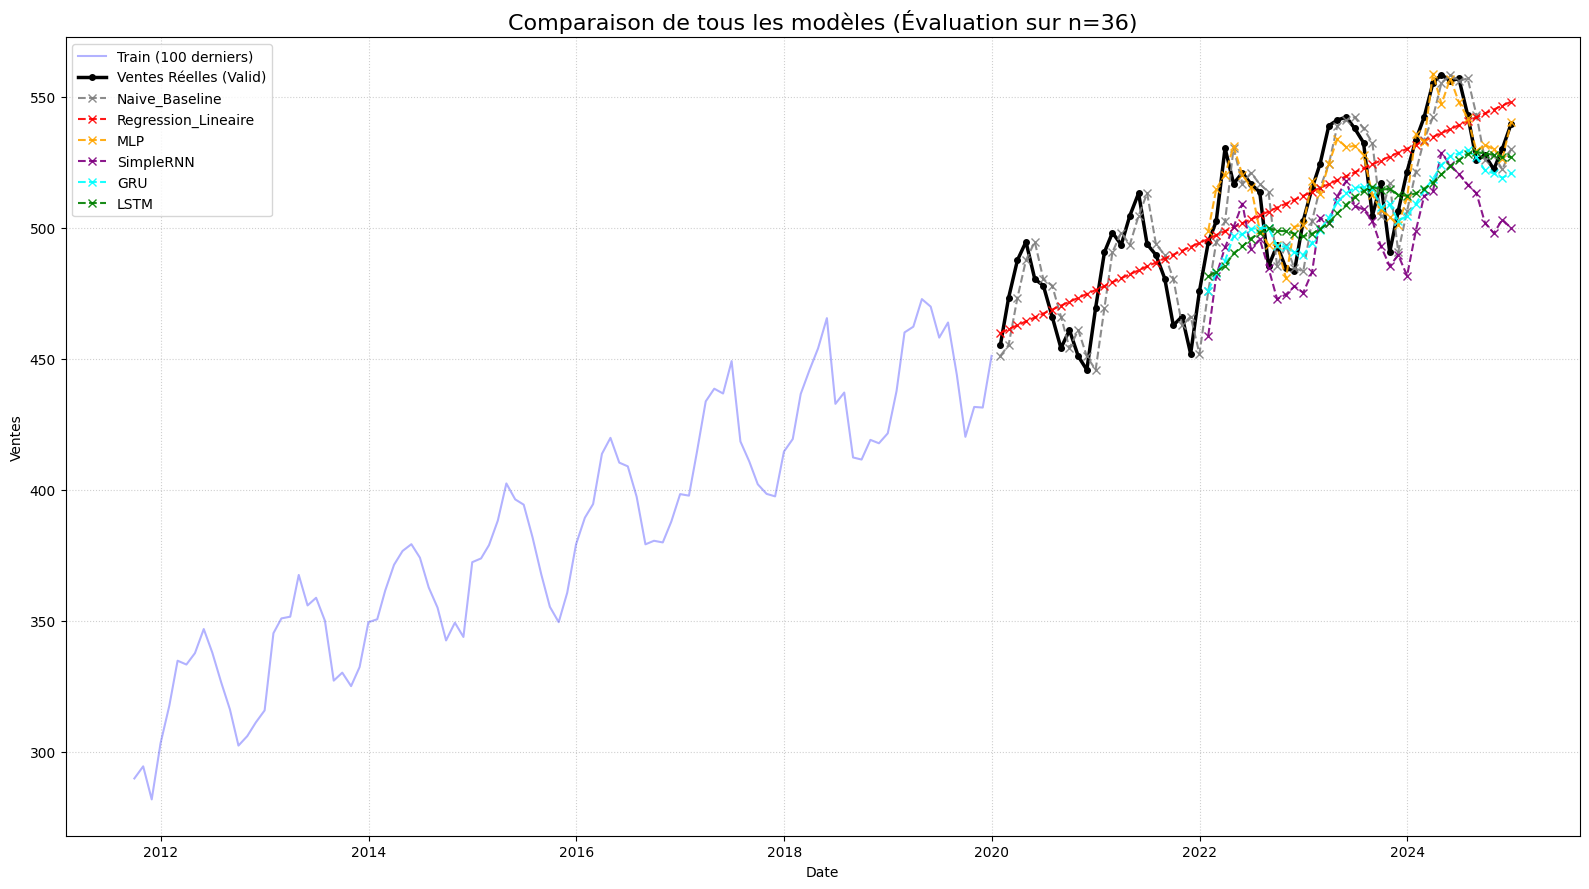

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import os

# --- Imports Scikit-Learn ---
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# --- Imports TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    SimpleRNN,
    LSTM,
    GRU,
    Flatten
)
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Supprimer les avertissements TF superflus
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# --- 1. Définir le chemin de sauvegarde (pour la fin) ---
SAVE_DIRECTORY = "/content/drive/MyDrive/Time_series"
# Assurez-vous que votre Drive est monté

# --- 2. Fonction de Métriques (inchangée) ---
def calculer_metriques(y_true, y_pred):
    y_true = pd.Series(y_true).dropna()
    y_pred = pd.Series(y_pred, index=y_true.index).dropna()

    # Assurer que seuls les index communs sont gardés
    common_index = y_true.index.intersection(y_pred.index)
    y_true_clean = y_true[common_index]
    y_pred_clean = y_pred[common_index]

    if len(y_true_clean) == 0:
        return {"MSE": np.nan, "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R2_Score": np.nan}

    mse = mean_squared_error(y_true_clean, y_pred_clean)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse,
        'MAPE': mape * 100, 'R2_Score': r2
    }

# --- 3. Simulation des Données (Robuste) ---
np.random.seed(42)
n = 300  # 25 ans de données
W = 24   # Fenêtre de 2 ans (capture la saisonnalité)
t = np.arange(n)
trend = 100 + 1.5 * t
seasonality = 25 * np.sin(2 * np.pi * t / 12)
noise = np.random.normal(0, 6, n)
sales = trend + seasonality + noise

date_index = pd.date_range(start='2000-01-01', periods=n, freq='M')
df = pd.DataFrame({'Ventes': sales}, index=date_index)

# --- 4. Préparation & Split ---
df['time_idx'] = np.arange(len(df))
df['Prediction_Naive'] = df['Ventes'].shift(1)

split_point = int(len(df) * 0.8) # 80/20 Split
train = df.iloc[0:split_point].copy() # 240 points
valid = df.iloc[split_point:].copy() # 60 points

print(f"Taille totale: {len(df)}, Train: {len(train)}, Valid: {len(valid)}")
print(f"Taille de fenêtre W = {W}. Points d'évaluation = {len(valid) - W}") # 60 - 24 = 36

# --- Index de Comparaison Équitable ---
# Tous les modèles seront évalués sur ces dates (les 36 dernières)
common_index = valid.index[W:]
y_true_common = valid.loc[common_index]['Ventes']

# Dictionnaires pour stocker les résultats
all_metrics = {}
all_predictions = {}

# --- 5. Modèles de Baseline (Naïf et RegLin) ---

print("\n--- Entraînement Modèle 1: Naïf (Baseline) ---")
y_pred_naive = valid['Prediction_Naive']
all_predictions['Naive_Baseline'] = y_pred_naive
# Calcul des métriques sur l'index commun
all_metrics['Naive_Baseline'] = calculer_metriques(y_true_common, y_pred_naive.loc[common_index])


print("--- Entraînement Modèle 2: Régression Linéaire (Baseline) ---")
features = ['time_idx']
model_reg = LinearRegression()
model_reg.fit(train[features], train['Ventes'])
predictions_reg = pd.Series(model_reg.predict(valid[features]), index=valid.index)
all_predictions['Regression_Lineaire'] = predictions_reg
all_metrics['Regression_Lineaire'] = calculer_metriques(y_true_common, predictions_reg.loc[common_index])

print("Baselines calculées.")

# --- 6. Préparation des Données pour le Deep Learning ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Ventes']])
valid_scaled = scaler.transform(valid[['Ventes']])

# Générateur Keras (le même pour tous les modèles)
# Il produit des batchs de shape [batch_size, W, 1] -> [batch_size, 24, 1]
generator = TimeseriesGenerator(
    train_scaled,
    train_scaled,
    length=W,
    batch_size=32
)

# Générateur de validation pour les prédictions
valid_generator = TimeseriesGenerator(
    valid_scaled,
    valid_scaled,
    length=W,
    batch_size=1
)

# --- 7. Définition et Entraînement des Modèles DL ---

# Modèle 3: MLP (Multi-Layer Perceptron)
print("\n--- Entraînement Modèle 3: MLP ---")
model_mlp = Sequential([
    # Le 'generator' donne [24, 1], 'Flatten' le transforme en (24)
    # pour que la couche Dense puisse le lire.
    Flatten(input_shape=[W, 1]),
    Dense(50, activation='relu'),
    Dense(1) # Sortie linéaire
])
model_mlp.compile(optimizer='adam', loss='mse')
model_mlp.fit(generator, epochs=50, verbose=0)


# Modèle 4: Simple RNN
print("--- Entraînement Modèle 4: SimpleRNN ---")
model_rnn = Sequential([
    # RNN attend l'input [W, 1]
    SimpleRNN(32, input_shape=[W, 1]),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(generator, epochs=50, verbose=0)


# Modèle 5: GRU
print("--- Entraînement Modèle 5: GRU ---")
model_gru = Sequential([
    GRU(32, input_shape=[W, 1]),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(generator, epochs=50, verbose=0)


# Modèle 6: LSTM
print("--- Entraînement Modèle 6: LSTM ---")
model_lstm = Sequential([
    LSTM(32, input_shape=[W, 1]),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(generator, epochs=50, verbose=0)

print("\nTous les modèles sont entraînés.")

# --- 8. Évaluation des Modèles DL ---

# Liste des modèles DL pour la boucle
dl_models = [
    ('MLP', model_mlp),
    ('SimpleRNN', model_rnn),
    ('GRU', model_gru),
    ('LSTM', model_lstm)
]

for name, model in dl_models:
    # Prédire sur le générateur de validation
    predictions_scaled_dl = model.predict(valid_generator)
    # Inverser la mise à l'échelle
    predictions_dl = scaler.inverse_transform(predictions_scaled_dl).flatten()
    # Créer une Série pandas alignée sur l'index commun
    pred_series_dl = pd.Series(predictions_dl, index=common_index)

    # Stocker les prédictions et les métriques
    all_predictions[name] = pred_series_dl
    all_metrics[name] = calculer_metriques(y_true_common, pred_series_dl)


# --- 9. Comparaison Équitable Finale ---
print("\n--- 🏁 Comparaison Équitable Finale 🏁 ---")
print(f"Évaluation sur les {len(y_true_common)} dernières observations (W={W}):\n")

df_final_compare = pd.DataFrame(all_metrics).round(4)
print(df_final_compare)

# --- 10. Sauvegarde de TOUTES les métriques ---
print("\n--- Sauvegarde des Métriques ---")
try:
    os.makedirs(SAVE_DIRECTORY, exist_ok=True)
    print(f"Dossier assuré d'exister : {SAVE_DIRECTORY}")

    for model_name, metrics_dict in all_metrics.items():
        file_path = os.path.join(SAVE_DIRECTORY, f"{model_name.lower()}_metrics.json")
        with open(file_path, 'w') as json_file:
            json.dump(metrics_dict, json_file, indent=4)
        print(f"Succès : '{model_name}' métriques sauvegardées dans {file_path}")

except Exception as e:
    print(f"ERREUR LORS DE LA SAUVEGARDE : {e}")
    print("Veuillez vérifier que votre Google Drive est bien monté ('/content/drive').")

# --- 11. Visualisation Finale ---
print("\n--- Génération du graphique de comparaison ---")
plt.figure(figsize=(16, 9))
plt.title(f'Comparaison de tous les modèles (Évaluation sur n={len(y_true_common)})', fontsize=16)

# Données (zoom sur la fin)
plt.plot(train.index[-100:], train['Ventes'].iloc[-100:], label='Train (100 derniers)', color='blue', alpha=0.3)
plt.plot(valid.index, valid['Ventes'], label='Ventes Réelles (Valid)', color='black', marker='o', markersize=4, linewidth=2.5)

# Couleurs pour les modèles
colors = {
    'Naive_Baseline': 'grey', 'Regression_Lineaire': 'red',
    'MLP': 'orange', 'SimpleRNN': 'purple', 'GRU': 'cyan', 'LSTM': 'green'
}

for model_name, predictions in all_predictions.items():
    if model_name in colors:
        plt.plot(predictions.index, predictions,
                 label=model_name,
                 color=colors[model_name],
                 linestyle='--',
                 marker='x',
                 alpha=0.9)

plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()